In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

In [86]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.style import reset_defaults, reset_orig

In [6]:
import time

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
%matplotlib inline

In [9]:
def separar_etiquetas(df, *args):
    """
        Funcion que separa las columnas en X e y
        La primera etiqueta se considera etiqueta objetivo
    """
    etiquetas = list(args)
    X = df.drop(etiquetas, axis=1)
    y = df[etiquetas[0]] # Etiqueta objetivo
    
    return (X, y)

In [10]:
def reset_config_yb():
    """
        Reset de las configuraciones globales de yellowbrick
        Para no alterar las gráficas de MatplotLib or Seaborn
    """
    reset_defaults()
    reset_orig()

In [11]:
def graf_error_pred(y_true, y_pred, clases: list):
    """
        Gráfica apilada de errores de predicciones a partir de una matriz de confusión 4x4.
    """
    
    x = clases

    cm = confusion_matrix(y_true, y_pred)
    cm_array = np.array(cm)
    y0 = cm_array[:,0] # Coger la columna indicada
    y1 = cm_array[:,1]
    y2 = cm_array[:,2]
    y3 = cm_array[:,3]
    
    plt.bar(x, y0, edgecolor='black', linewidth=.3)
    plt.bar(x, y1, bottom=y0, edgecolor='black', linewidth=.3)
    plt.bar(x, y2, bottom=y0+y1, edgecolor='black', linewidth=.3)
    plt.bar(x, y3, bottom=y0+y1+y2, edgecolor='black', linewidth=.3)
    plt.xlabel("Actual class")
    plt.ylabel("Number of predicted class")
    plt.legend(clases, bbox_to_anchor=(1.3, 0.5), loc='center right')
    plt.show()

In [12]:
df = pd.read_csv('dataset/dataset_con_atrib_no_dup.csv') # Dataset final sin duplicados

In [13]:
df_copy = df.copy()

df_copy

,url,type,longitud_url,longitud_hostname,longitud_de_ruta,longitud_de_consulta,contiene_https,contiene_ip,contiene_php,contiene_html,contiene_doble_barras,profundidad_de_la_ruta,acortadores_de_url,num_digitos,num_caracteres_especiales,dom_dias_activo,dom_dias_hasta_expiracion,entropia
0,http://www.osn-solutions.nl/index.php/nl/over-osn,defacement,49,20,22,0,0,0,1,0,0,3,0,0,8,0,-1,4.012598
1,http://msb.jcw.mybluehost.me/web.html,phishing,37,21,9,0,0,0,0,1,0,1,0,0,5,2803,118,3.884601
2,https://sites.google.com/view/qwzxvcax/home,phishing,43,16,19,0,1,0,0,0,0,3,0,0,5,9764,1557,4.144418
3,https://pub-fc6dc735ff68445cae5ca2d946a8bfbb.r...,phishing,61,43,10,0,1,0,0,1,0,1,0,16,5,655,440,4.716982
4,https://tinyurl.com/4vz6vmm2/a.html?syl=1x165b...,phishing,125,11,16,89,1,0,0,1,0,2,1,32,11,8169,1692,5.429293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19129,http://smgtc.com/old/PMV/,phishing,25,9,9,0,0,0,0,0,0,3,0,0,4,4645,103,3.749275
19130,https://mitsui-jyuku.mixh.jp/uploads/3601q2w3e...,malware,56,20,28,0,1,0,0,0,0,2,0,9,6,2143,51,4.663800
19131,https://bt-mail-service-f245c0.webflow.io/,phishing,42,33,1,0,1,0,0,0,0,0,0,4,6,4050,1428,4.445307
19132,http://111.43.223.83:56977/Mozi.m,malware,33,13,7,0,0,1,0,0,0,1,0,15,6,0,-1,4.127283


### Codificación de la columna type

In [13]:
# Convertir la columna type a categorica
# le = LabelEncoder()
# le.fit(df_copy['type'])

# Guardar el encoder realizado para usos posteriores. Ejecutar solo una vez
# Más info: https://stackoverflow.com/questions/28656736/using-scikits-labelencoder-correctly-across-multiple-programs

# np.save('clases_le.npy', le.classes_)

In [14]:
# Cargar las clases codificadas guardadas
le = LabelEncoder()
le.classes_ = np.load('gui/escalador_encoder/clases_le.npy', allow_pickle=True)

# Codificar la columna type a categorica
df_copy['clases'] = le.transform(df_copy['type'])

In [15]:
# Imprimir las asignaciones realizadas por LabelEncoder
asignacion_clases_le = {i: etiqueta for i, etiqueta in enumerate(le.classes_)}
asignacion_clases_le

{0: 'benign', 1: 'defacement', 2: 'malware', 3: 'phishing'}

### División de los datos en train (70%), val (15%), test (15%)

In [16]:
# Division 70/30 en train y auxiliar_test
train_set, test_set = train_test_split(df_copy, test_size=0.3, random_state=23, shuffle=True)

In [17]:
# Division en 50/50 en validacion y test (15/15)
val_set, test_set = train_test_split(test_set, test_size=0.5, random_state=23, shuffle=True)

In [18]:
print(f"Tamaño del subconjunto train: {len(train_set)}")
print(f"Tamaño del subconjunto validacion: {len(val_set)}")
print(f"Tamaño del subconjunto test: {len(test_set)}")

Tamaño del subconjunto train: 13393
Tamaño del subconjunto validacion: 2870
Tamaño del subconjunto test: 2871


### Separar las columnas en X e y

In [19]:
X_train, y_train = separar_etiquetas(train_set, 'clases', 'url', 'type')
X_val, y_val = separar_etiquetas(val_set, 'clases', 'url', 'type')
X_test, y_test = separar_etiquetas(test_set, 'clases', 'url', 'type')

### Escalado de datos

In [19]:
# import pickle

# Guardar el escalador para usos futuros, ejecutar solamente la primera vez
# Más info: https://stackoverflow.com/questions/41993565/save-minmaxscaler-model-in-sklearn

# scaler = RobustScaler()
# X_train_scaled = scaler.fit(X_train)
# rbscaler_multi = 'rbscaler_multi.sav'
# pickle.dump(scaler, open(rbscaler_multi, 'wb'))

In [20]:
import pickle

# Cargar el escalador guardado
rbscaler_multi = 'gui/escalador_encoder/rbscaler_multi.sav'
scaler = pickle.load(open(rbscaler_multi, 'rb'))

In [21]:
# Escalar los datos de entrenamientos
X_train_scaled = scaler.transform(X_train)
X_train_scaled

array([[-0.08695652,  0.44444444,  0.125     , ...,  0.72863625,
         0.44648318, -0.55665508],
       [ 0.73913043,  0.44444444,  1.70833333, ...,  0.90975548,
         0.52293578,  0.3026196 ],
       [ 0.26086957, -0.33333333,  1.08333333, ...,  0.68187547,
        -0.29051988,  0.32489372],
       ...,
       [-0.52173913, -0.33333333, -0.41666667, ..., -0.25371817,
        -0.29051988, -1.01205706],
       [-0.32608696,  0.66666667, -0.41666667, ..., -0.25371817,
        -0.29051988,  0.11170617],
       [ 0.86956522, -0.33333333,  1.79166667, ...,  0.69725233,
         1.21100917,  0.70620817]])

In [22]:
# Escalado de los datos de validacion
X_val_scaled = scaler.transform(X_val)

# Escalado de los datos de test
X_test_scaled = scaler.transform(X_test)

### Experimento 1: Modelos preliminares

 Modelo:  <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 Recall sobre conjunto de validación:   94.56%
 Informe de las métricas 
              precision    recall  f1-score   support

      benign       0.94      0.93      0.93       751
  defacement       0.90      0.97      0.93       711
     malware       0.98      0.95      0.96       661
    phishing       0.98      0.94      0.96       747

    accuracy                           0.95      2870
   macro avg       0.95      0.95      0.95      2870
weighted avg       0.95      0.95      0.95      2870

 Matriz de confusión 


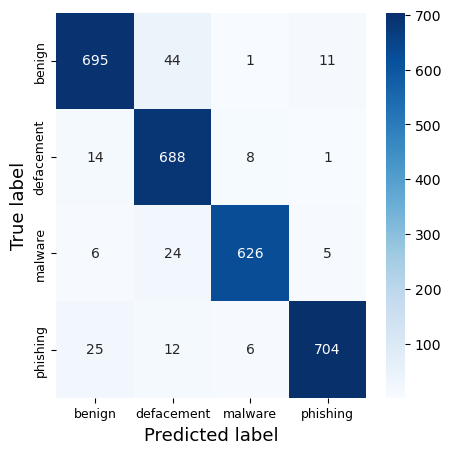

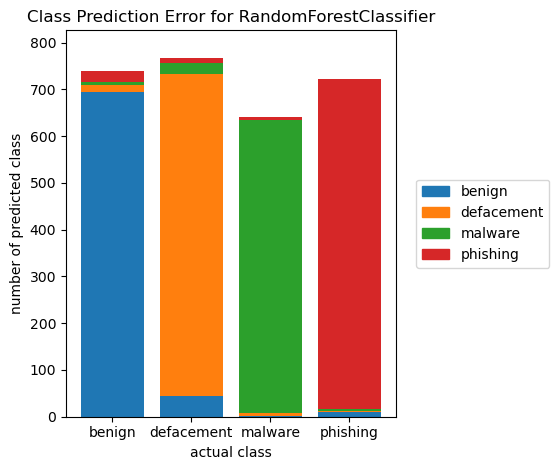

----------------------------------------------------

 Modelo:  <class 'sklearn.svm._classes.LinearSVC'>
 Recall sobre conjunto de validación:   81.87%
 Informe de las métricas 
              precision    recall  f1-score   support

      benign       0.81      0.93      0.86       751
  defacement       0.82      0.84      0.83       711
     malware       0.90      0.62      0.74       661
    phishing       0.81      0.88      0.84       747

    accuracy                           0.82      2870
   macro avg       0.83      0.82      0.82      2870
weighted avg       0.83      0.82      0.82      2870

 Matriz de confusión 


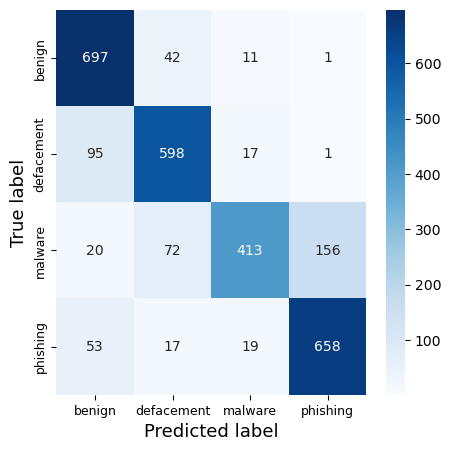

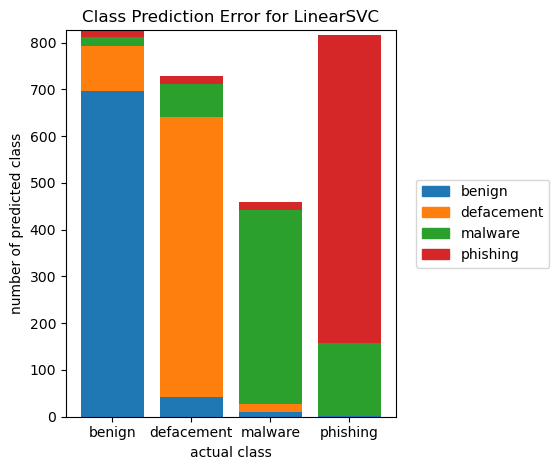

----------------------------------------------------

 Modelo:  <class 'sklearn.linear_model._logistic.LogisticRegression'>
 Recall sobre conjunto de validación:   82.17%
 Informe de las métricas 
              precision    recall  f1-score   support

      benign       0.83      0.91      0.87       751
  defacement       0.82      0.83      0.83       711
     malware       0.81      0.70      0.75       661
    phishing       0.84      0.85      0.84       747

    accuracy                           0.83      2870
   macro avg       0.82      0.82      0.82      2870
weighted avg       0.83      0.83      0.82      2870

 Matriz de confusión 


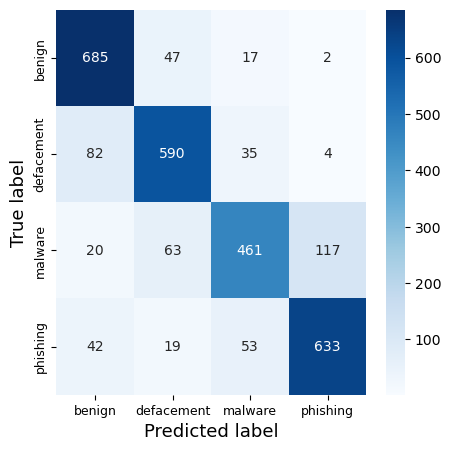

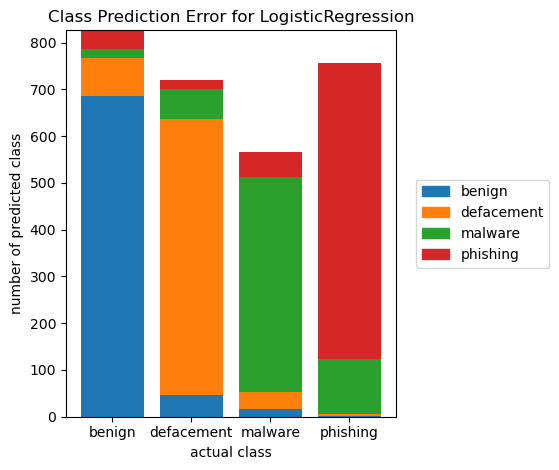

----------------------------------------------------

 Modelo:  <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
 Recall sobre conjunto de validación:   91.45%
 Informe de las métricas 
              precision    recall  f1-score   support

      benign       0.90      0.93      0.91       751
  defacement       0.85      0.91      0.88       711
     malware       0.94      0.92      0.93       661
    phishing       0.98      0.90      0.94       747

    accuracy                           0.91      2870
   macro avg       0.92      0.91      0.91      2870
weighted avg       0.92      0.91      0.91      2870

 Matriz de confusión 


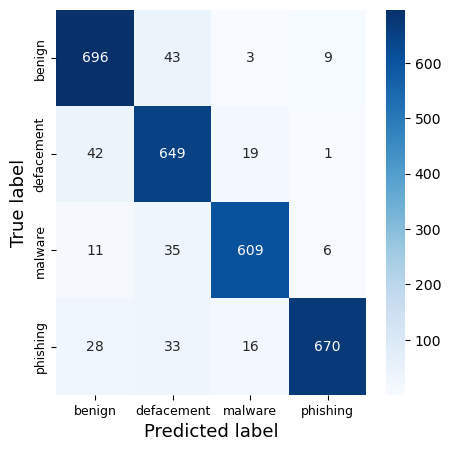

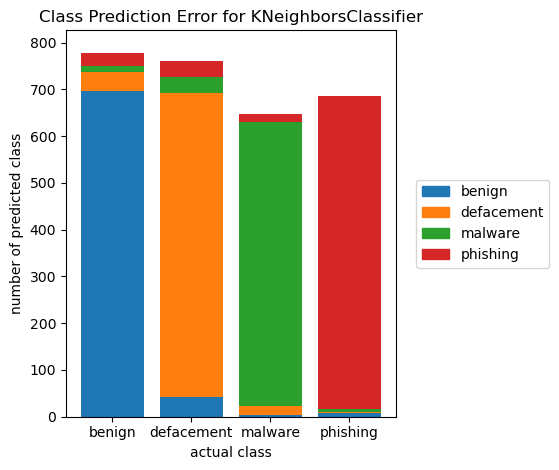

----------------------------------------------------



In [23]:
modelos = [RandomForestClassifier, LinearSVC, LogisticRegression, KNeighborsClassifier]

recall = []

COLOR = '\33[46m'
SUBRAYADO = '\033[4m'
FIN = '\033[0m'

for m in modelos:
    print(COLOR, 'Modelo:', FIN, m)
    
    try:
        modelo = m(random_state=23)
    except Exception:
        modelo = m()                                        # El modelo de k-vecinos no tiene argumento random_state
    
    modelo.fit(X_train_scaled, y_train)                     # Entrenar con los datos de entrenamientos escalados
    pred = modelo.predict(X_val_scaled)                     # Prediccion sobre el conjunto de validacion
    recall_scr = recall_score(y_val, pred, average='macro') # Calcular el recall de cada modelo
    recall.append(recall_scr)
    print(SUBRAYADO, 'Recall sobre conjunto de validación: ', FIN, f"{recall_scr*100:.2f}%")
    
    # Informe de métricas sobre el conjunto de validación
    print(SUBRAYADO ,'Informe de las métricas', FIN)
    print(classification_report(y_val, pred, target_names=list(le.classes_)))
    
    reset_config_yb()
    
    # Matriz de confusión sobre el conjunto de validación
    print(SUBRAYADO, 'Matriz de confusión', FIN)
    cm = confusion_matrix(y_val, pred)
    plt.figure(figsize=(5,5))
    cm = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(le.classes_), yticklabels=list(le.classes_))
    cm.set_xlabel('Predicted label', fontsize=13)
    cm.set_ylabel('True label', fontsize=13)
    plt.xticks(rotation=0, fontsize=9)
    plt.yticks(fontsize=9)
    plt.show()
    
    # Error de predicciones por clases sobre el conjunto de validación
    visualizer = ClassPredictionError(
       modelo, classes=list(le.classes_)
    )

    visualizer.fit(X_train_scaled, y_train)
    visualizer.score(X_val_scaled, y_val)
    visualizer.ax.set_xticklabels(visualizer.ax.get_xticklabels(), rotation=0, ha="center")
    visualizer.show()
    print("----------------------------------------------------")
    print()

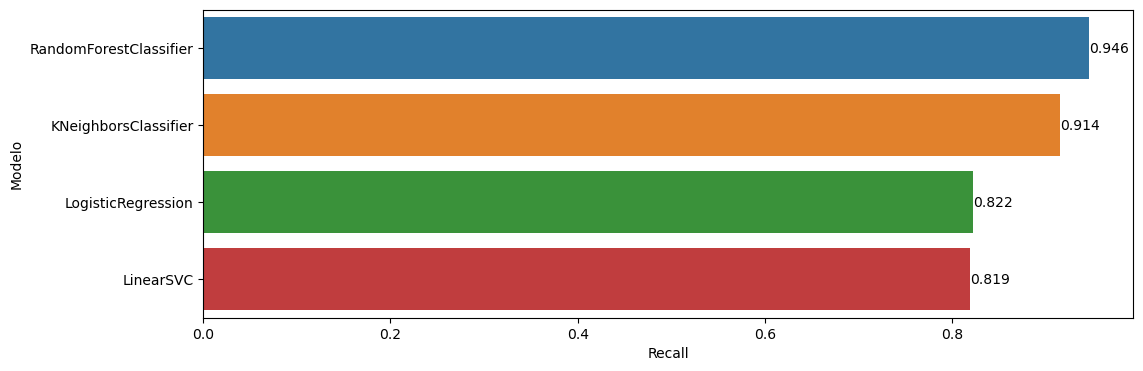

In [24]:
resultados_modelos = pd.DataFrame(
    {
        'Modelo': ['RandomForestClassifier', 'LinearSVC', 'LogisticRegression', 'KNeighborsClassifier'],
        'Recall': recall
    }
)

res_sorted = resultados_modelos.sort_values(by='Recall', ascending=False) # Orden descendente

plt.figure(figsize=(12,4))
ax = sns.barplot(x='Recall', y='Modelo', data=res_sorted)
for i in ax.containers:
    ax.bar_label(i, fmt='%.3f')
plt.show()

### Experimento 2: Modelos con selección de atributos

Veamos si podemos mejorar el recall obtenido seleccionando las columnas más influyente en la decisión del modelo Random Forest. Y posterior aplicar a los otros modelos.

In [25]:
clf_rf = RandomForestClassifier(random_state=1)
clf_rf.fit(X_train_scaled, y_train)

importancia_de_atributos = pd.Series(clf_rf.feature_importances_, index=list(X_train))
atributos_ordenados = importancia_de_atributos.sort_values(ascending=False)

atributos_ordenados

contiene_https               0.209298
dom_dias_activo              0.133282
longitud_de_ruta             0.101034
num_digitos                  0.078386
longitud_hostname            0.065964
profundidad_de_la_ruta       0.059627
longitud_url                 0.057953
entropia                     0.056285
contiene_ip                  0.052628
contiene_php                 0.047851
dom_dias_hasta_expiracion    0.045597
longitud_de_consulta         0.037295
num_caracteres_especiales    0.036285
contiene_html                0.015093
acortadores_de_url           0.002963
contiene_doble_barras        0.000460
dtype: float64

Vamos a establecer el corte de la importancia de atributos hasta 'contiene_ip', es decir, pasar de 16 atributos originales a 9 atributos.

In [26]:
col = list(atributos_ordenados.head(9).index)

col

['contiene_https',
 'dom_dias_activo',
 'longitud_de_ruta',
 'num_digitos',
 'longitud_hostname',
 'profundidad_de_la_ruta',
 'longitud_url',
 'entropia',
 'contiene_ip']

In [27]:
X_train_reduced = X_train[col] # Conjunto reducido con 9 atributos sin escalar
X_train_reduced

,contiene_https,dom_dias_activo,longitud_de_ruta,num_digitos,longitud_hostname,profundidad_de_la_ruta,longitud_url,entropia,contiene_ip
5714,0,7794,13,0,22,1,42,3.894845,0
6609,0,9231,51,0,22,4,80,4.396039,0
194,0,7423,36,3,15,4,58,4.409031,0
8447,0,0,1,0,22,0,30,3.847743,0
14781,1,2202,83,11,19,3,118,5.065119,0
...,...,...,...,...,...,...,...,...,...
6175,0,6179,15,0,17,2,39,4.025930,0
9704,1,13719,22,2,21,2,51,4.735672,0
11190,0,0,0,0,15,0,22,3.629220,0
9256,0,0,0,2,24,0,31,4.284684,0


In [28]:
# Usar nuevo escalador, en este caso al pasar a 9 columnas se debe usar otro escalador diferente al usado para 16
scaler9 = RobustScaler()

X_train_red_scaled = scaler9.fit_transform(X_train_reduced)

In [29]:
# Conjunto de validacion reducido y escalado
X_val_reduced = X_val[col]
X_val_red_scaled = scaler9.transform(X_val_reduced)

### Modelos aplicando reducción de columnas de entradas

 Modelo:  <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 Recall sobre conjunto de validación:   93.30%
 Informe de las métricas 
              precision    recall  f1-score   support

      benign       0.93      0.91      0.92       751
  defacement       0.87      0.96      0.91       711
     malware       0.98      0.92      0.95       661
    phishing       0.97      0.94      0.96       747

    accuracy                           0.93      2870
   macro avg       0.94      0.93      0.93      2870
weighted avg       0.94      0.93      0.93      2870

 Matriz de confusión 


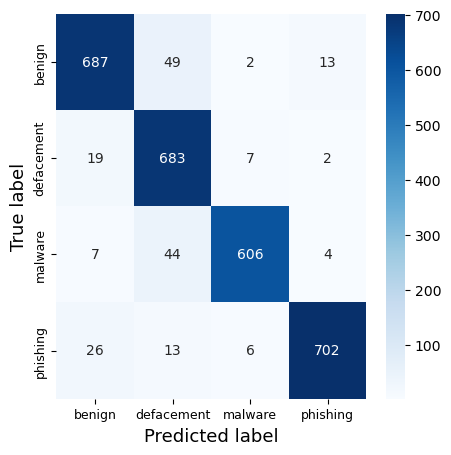

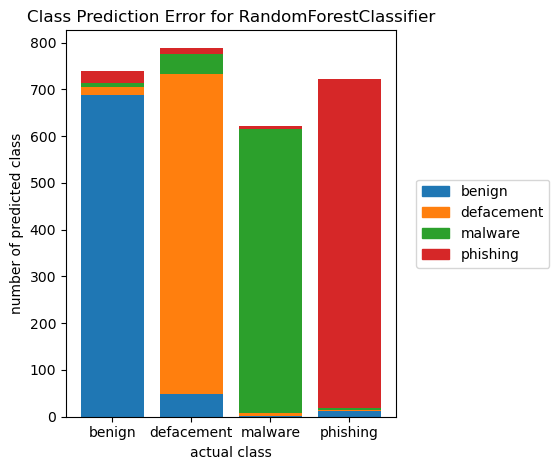

-----------------------------------------------------

 Modelo:  <class 'sklearn.svm._classes.LinearSVC'>
 Recall sobre conjunto de validación:   80.43%
 Informe de las métricas 
              precision    recall  f1-score   support

      benign       0.80      0.93      0.86       751
  defacement       0.78      0.84      0.81       711
     malware       0.90      0.58      0.71       661
    phishing       0.80      0.87      0.83       747

    accuracy                           0.81      2870
   macro avg       0.82      0.80      0.80      2870
weighted avg       0.82      0.81      0.81      2870

 Matriz de confusión 


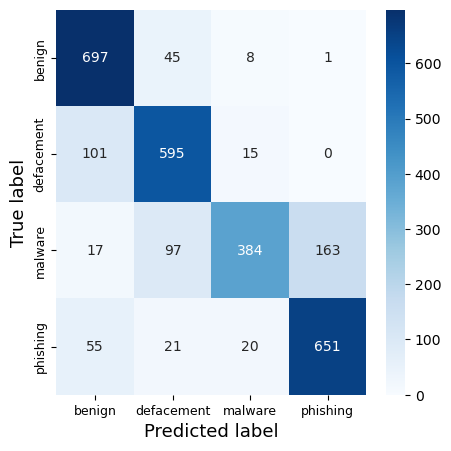

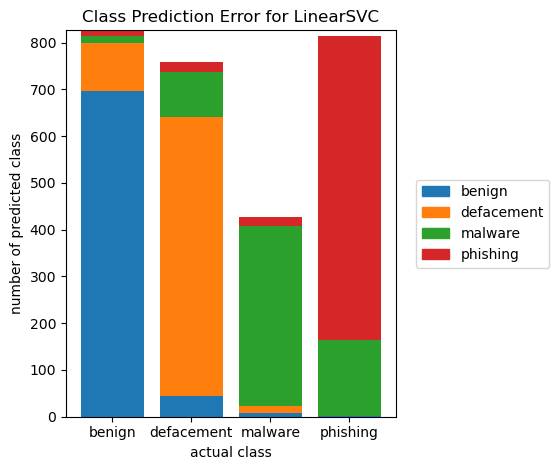

-----------------------------------------------------

 Modelo:  <class 'sklearn.linear_model._logistic.LogisticRegression'>
 Recall sobre conjunto de validación:   81.50%
 Informe de las métricas 
              precision    recall  f1-score   support

      benign       0.82      0.92      0.87       751
  defacement       0.79      0.84      0.81       711
     malware       0.83      0.67      0.74       661
    phishing       0.84      0.83      0.84       747

    accuracy                           0.82      2870
   macro avg       0.82      0.81      0.81      2870
weighted avg       0.82      0.82      0.82      2870

 Matriz de confusión 


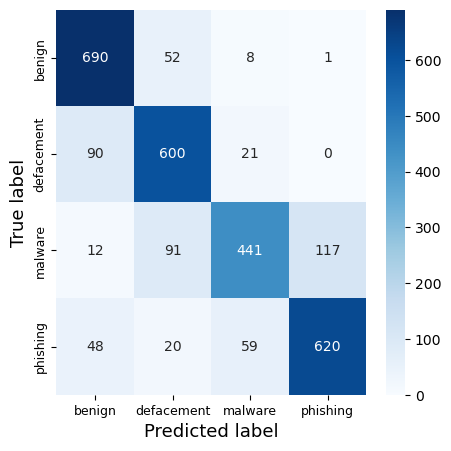

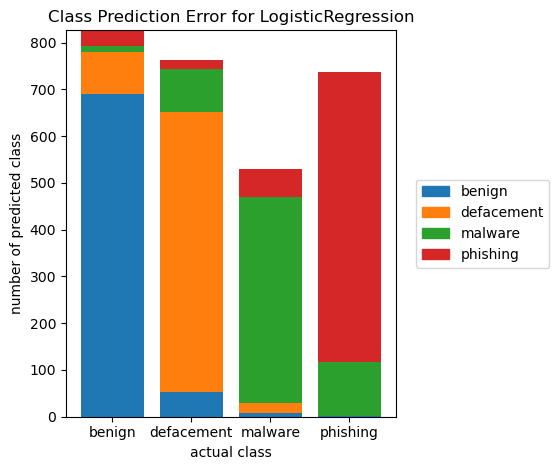

-----------------------------------------------------

 Modelo:  <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
 Recall sobre conjunto de validación:   91.05%
 Informe de las métricas 
              precision    recall  f1-score   support

      benign       0.89      0.91      0.90       751
  defacement       0.84      0.91      0.88       711
     malware       0.93      0.91      0.92       661
    phishing       0.98      0.91      0.94       747

    accuracy                           0.91      2870
   macro avg       0.91      0.91      0.91      2870
weighted avg       0.91      0.91      0.91      2870

 Matriz de confusión 


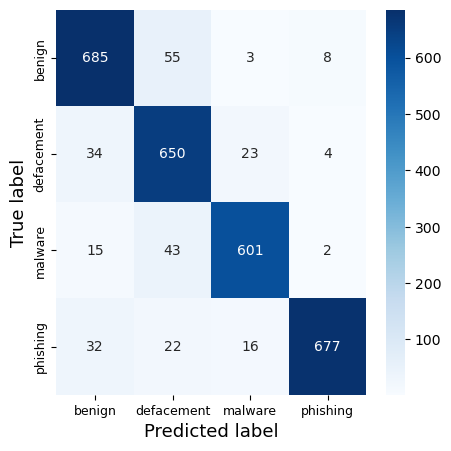

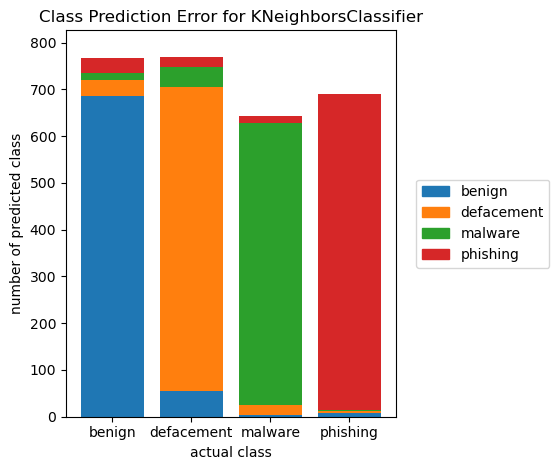

-----------------------------------------------------



In [30]:
modelos = [RandomForestClassifier, LinearSVC, LogisticRegression, KNeighborsClassifier]

recall = []

COLOR = '\33[46m'
SUBRAYADO = '\033[4m'
FIN = '\033[0m'

for m in modelos:
    print(COLOR, 'Modelo:', FIN, m)
    
    try:
        modelo = m(random_state=23)
    except Exception:
        modelo = m()                                        # El modelo de k-vecinos no tiene argumento random_state
        
    modelo.fit(X_train_red_scaled, y_train)                 # Entrenar con los datos de entrenamientos reducidos escalados
    pred = modelo.predict(X_val_red_scaled)                 # Prediccion sobre el conjunto de validacion reducidos esclados
    recall_scr = recall_score(y_val, pred, average='macro') # Calcular el recall de cada modelo
    recall.append(recall_scr)
    print(SUBRAYADO, 'Recall sobre conjunto de validación: ', FIN, f"{recall_scr*100:.2f}%")
    
    print(SUBRAYADO ,'Informe de las métricas', FIN)
    print(classification_report(y_val, pred, target_names=list(le.classes_)))
    
    reset_config_yb()
    
    print(SUBRAYADO, 'Matriz de confusión', FIN)
    cm = confusion_matrix(y_val, pred)
    plt.figure(figsize=(5,5))
    cm = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(le.classes_), yticklabels=list(le.classes_))
    cm.set_xlabel('Predicted label', fontsize=13)
    cm.set_ylabel('True label', fontsize=13)
    plt.xticks(rotation=0, fontsize=9)
    plt.yticks(fontsize=9)
    plt.show()

    # Error de predicciones por clases sobre el conjunto de validación reducido
    visualizer = ClassPredictionError(
       modelo, classes=list(le.classes_)
    )

    visualizer.fit(X_train_red_scaled, y_train)
    visualizer.score(X_val_red_scaled, y_val)
    visualizer.ax.set_xticklabels(visualizer.ax.get_xticklabels(), rotation=0, ha="center")
    visualizer.show()
    
    print("-----------------------------------------------------")
    print()

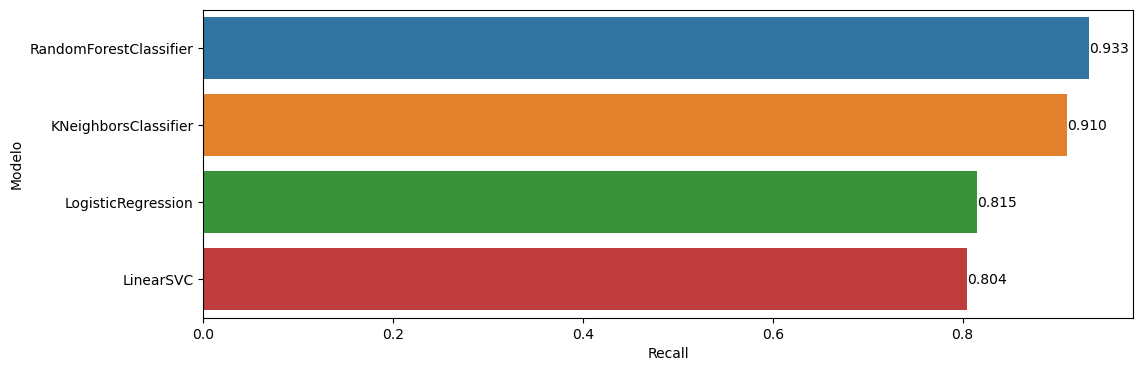

In [31]:
resultados_modelos_2 = pd.DataFrame(
    {
        'Modelo': ['RandomForestClassifier', 'LinearSVC', 'LogisticRegression', 'KNeighborsClassifier'],
        'Recall': recall
    }
)

res_sorted_2 = resultados_modelos_2.sort_values(by='Recall', ascending=False)

reset_config_yb()
plt.figure(figsize=(12,4))
ax = sns.barplot(x='Recall', y='Modelo', data=res_sorted_2)
for i in ax.containers:
    ax.bar_label(i, fmt='%.3f')
plt.show()

Conclusión: al remover columnas se ha empeorado los resultados

### Experimento 3: Mejorando los modelos mediante hiperparámetros

In [32]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [33]:
espacio_de_busqueda = {
    'Random Forest': {
        'modelo': RandomForestClassifier(random_state=23),
        'params': {
            'n_estimators': randint(10, 200),
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_features': [None, 'sqrt', 'log2'],
            'min_samples_leaf': randint(1, 20),
            'max_depth': randint(1, 20)
        }
    },
    'LinearSVM': {
        'modelo': LinearSVC(random_state=23),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'loss': ['hinge', 'squared_hinge']
        }
    },
    'LogisticRegression': {
        'modelo': LogisticRegression(random_state=23),
        'params': {
            'penalty': ['l1','l2', 'elasticnet', None],
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
        }
    },
    'KNeighborsClassifier': {
        'modelo': KNeighborsClassifier(),
        'params':{
            'n_neighbors': randint(3, 20),
            'weights': ['uniform', 'distance'],
            'metric': ['minkowski', 'euclidean', 'manhattan', 'haversine', 'cosine']            
        }       
    }    
}

In [34]:
resultados_busqueda = []                      # Guardar resultados de la busqueda

for nombre_modelo, modelo_parametro in espacio_de_busqueda.items():
    rs = RandomizedSearchCV(
        estimator = modelo_parametro['modelo'],
        param_distributions= modelo_parametro['params'],
        n_iter=20,                            # 20 iteraciones
        cv=10,                                # Validacion cruzada de 10
        scoring='recall_weighted',            # Evaluar recall
        random_state=23
    )
    
    rs.fit(X_train_scaled, y_train)           # Entrenar con datos de entrenamiento escalado
    
    resultados_busqueda.append({
        'Modelo': nombre_modelo,
        'Mejor score recall': rs.best_score_,
        'Mejores parametros': rs.best_params_,
        'Mejor estimador': rs.best_estimator_
    })

In [35]:
for resultado in resultados_busqueda:
    print(f"Modelo: {resultado['Modelo']}")
    print(f"Mejor score recall: {resultado['Mejor score recall']}")
    print(f"Mejores parametros: {resultado['Mejores parametros']}")
    print(f"Mejor estimador: {resultado['Mejor estimador']}")
    print("-------------------------------------")

Modelo: Random Forest
Mejor score recall: 0.9452698605553265
Mejores parametros: {'criterion': 'gini', 'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 114}
Mejor estimador: RandomForestClassifier(max_depth=19, min_samples_leaf=2, n_estimators=114,
                       random_state=23)
-------------------------------------
Modelo: LinearSVM
Mejor score recall: 0.8393191064840101
Mejores parametros: {'penalty': 'l2', 'loss': 'squared_hinge', 'C': 100}
Mejor estimador: LinearSVC(C=100, random_state=23)
-------------------------------------
Modelo: LogisticRegression
Mejor score recall: 0.8482039392284284
Mejores parametros: {'solver': 'newton-cg', 'penalty': None, 'C': 0.001}
Mejor estimador: LogisticRegression(C=0.001, penalty=None, random_state=23, solver='newton-cg')
-------------------------------------
Modelo: KNeighborsClassifier
Mejor score recall: 0.9261565213514207
Mejores parametros: {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance

### Modelos con hiperparámetros

 Modelo:  RandomForestClassifier(max_depth=19, min_samples_leaf=2, n_estimators=114,
                       random_state=23)
 Recall sobre conjunto de validación:   94.24%
 Informe de las métricas 
              precision    recall  f1-score   support

      benign       0.94      0.92      0.93       751
  defacement       0.88      0.97      0.92       711
     malware       0.98      0.94      0.96       661
    phishing       0.98      0.94      0.96       747

    accuracy                           0.94      2870
   macro avg       0.94      0.94      0.94      2870
weighted avg       0.94      0.94      0.94      2870

 Matriz de confusión 


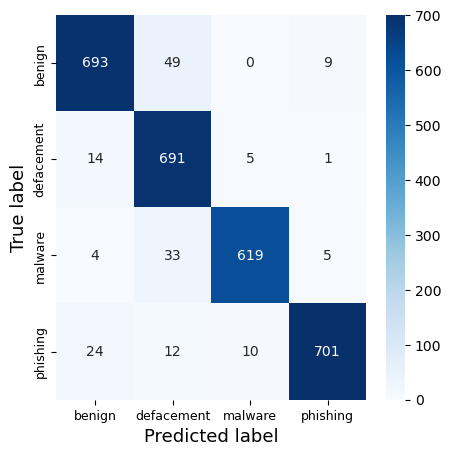

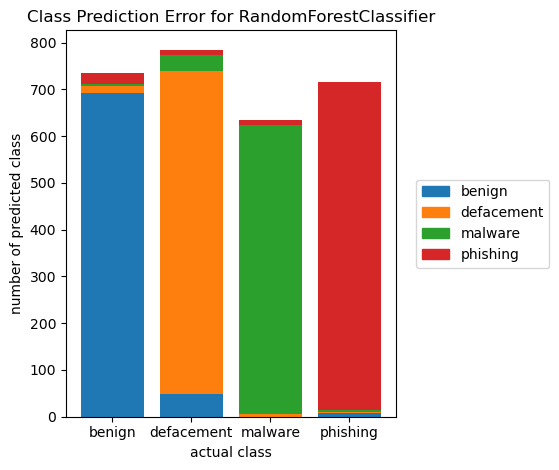

-----------------------------------------------------

 Modelo:  LinearSVC(C=100, random_state=23)
 Recall sobre conjunto de validación:   81.88%
 Informe de las métricas 
              precision    recall  f1-score   support

      benign       0.81      0.93      0.86       751
  defacement       0.82      0.84      0.83       711
     malware       0.90      0.63      0.74       661
    phishing       0.81      0.88      0.84       747

    accuracy                           0.82      2870
   macro avg       0.83      0.82      0.82      2870
weighted avg       0.83      0.82      0.82      2870

 Matriz de confusión 


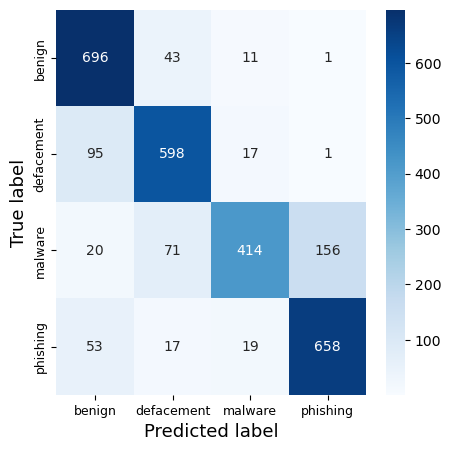

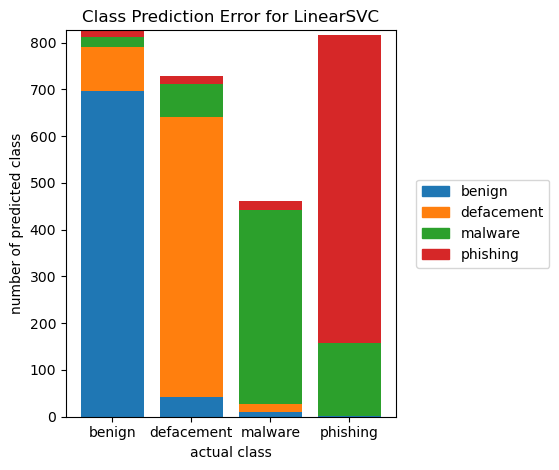

-----------------------------------------------------

 Modelo:  LogisticRegression(C=0.001, penalty=None, random_state=23, solver='newton-cg')
 Recall sobre conjunto de validación:   84.11%
 Informe de las métricas 
              precision    recall  f1-score   support

      benign       0.84      0.92      0.88       751
  defacement       0.82      0.85      0.83       711
     malware       0.86      0.74      0.79       661
    phishing       0.87      0.86      0.86       747

    accuracy                           0.84      2870
   macro avg       0.85      0.84      0.84      2870
weighted avg       0.85      0.84      0.84      2870

 Matriz de confusión 


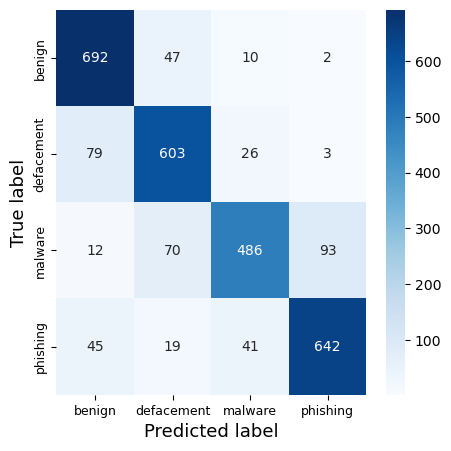

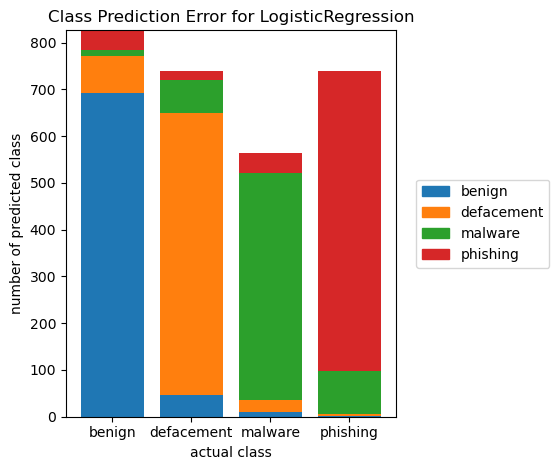

-----------------------------------------------------

 Modelo:  KNeighborsClassifier(metric='manhattan', n_neighbors=4, weights='distance')
 Recall sobre conjunto de validación:   92.75%
 Informe de las métricas 
              precision    recall  f1-score   support

      benign       0.92      0.91      0.92       751
  defacement       0.87      0.94      0.90       711
     malware       0.95      0.95      0.95       661
    phishing       0.97      0.91      0.94       747

    accuracy                           0.93      2870
   macro avg       0.93      0.93      0.93      2870
weighted avg       0.93      0.93      0.93      2870

 Matriz de confusión 


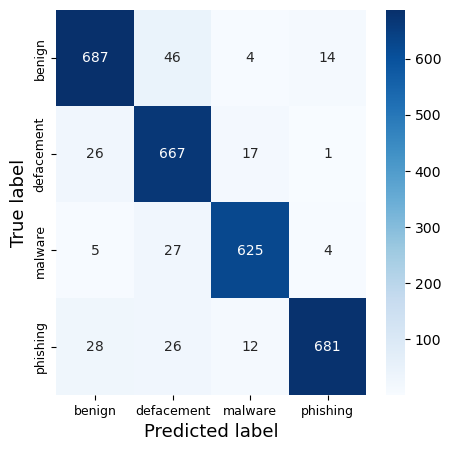

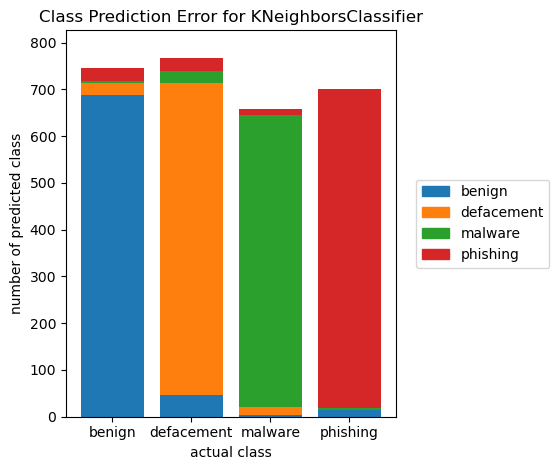

-----------------------------------------------------



In [36]:
modelos = [
    resultados_busqueda[0]['Mejor estimador'], # Modelo de Random Forest con los mejores parametros
    resultados_busqueda[1]['Mejor estimador'], # Modelo de LinearSVM
    resultados_busqueda[2]['Mejor estimador'], # Modelo de LogisticRegression
    resultados_busqueda[3]['Mejor estimador']  # Modelo de K-neighbors
]

recall = []

COLOR = '\33[46m'
SUBRAYADO = '\033[4m'
FIN = '\033[0m'

for m in modelos:
    print(COLOR, 'Modelo:', FIN, m)
    modelo = m 
    modelo.fit(X_train_scaled, y_train)                     # Entrenar con los datos de entrenamientos escalados
    pred = modelo.predict(X_val_scaled)                     # Prediccion sobre el conjunto de validacion
    recall_scr = recall_score(y_val, pred, average='macro') # Calcular el recall de cada modelo
    recall.append(recall_scr)
    print(SUBRAYADO, 'Recall sobre conjunto de validación: ', FIN, f"{recall_scr*100:.2f}%")
    
    print(SUBRAYADO ,'Informe de las métricas', FIN)
    print(classification_report(y_val, pred, target_names=list(le.classes_)))
    
    print(SUBRAYADO, 'Matriz de confusión', FIN)
    cm = confusion_matrix(y_val, pred)
    plt.figure(figsize=(5,5))
    cm = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(le.classes_), yticklabels=list(le.classes_))
    cm.set_xlabel('Predicted label', fontsize=13)
    cm.set_ylabel('True label', fontsize=13)
    plt.xticks(rotation=0, fontsize=9)
    plt.yticks(fontsize=9)
    plt.show()
    
    # Error de predicciones por clases sobre el conjunto de validación
    visualizer = ClassPredictionError(
       modelo, classes=list(le.classes_)
    )

    visualizer.fit(X_train_scaled, y_train)
    visualizer.score(X_val_scaled, y_val)
    visualizer.ax.set_xticklabels(visualizer.ax.get_xticklabels(), rotation=0, ha="center")
    visualizer.show()
    
    print("-----------------------------------------------------")
    print()

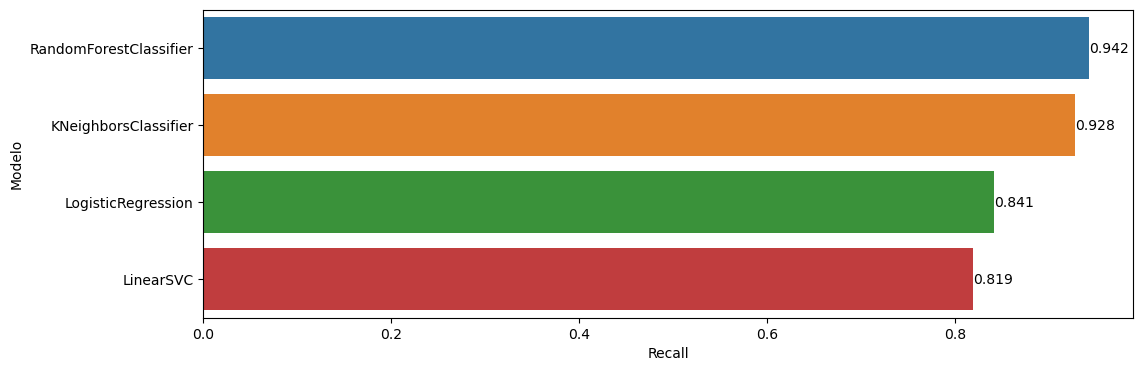

In [37]:
resultados_modelos_3 = pd.DataFrame(
    {
        'Modelo': ['RandomForestClassifier', 'LinearSVC', 'LogisticRegression', 'KNeighborsClassifier'],
        'Recall': recall
    }
)

res_sorted_3 = resultados_modelos_3.sort_values(by='Recall', ascending=False)

plt.figure(figsize=(12,4))
ax = sns.barplot(x='Recall', y='Modelo', data=res_sorted_3)
for i in ax.containers:
    ax.bar_label(i, fmt='%.3f')
plt.show()

### Gráfica apilada comparativa de los tres experimentos realizados

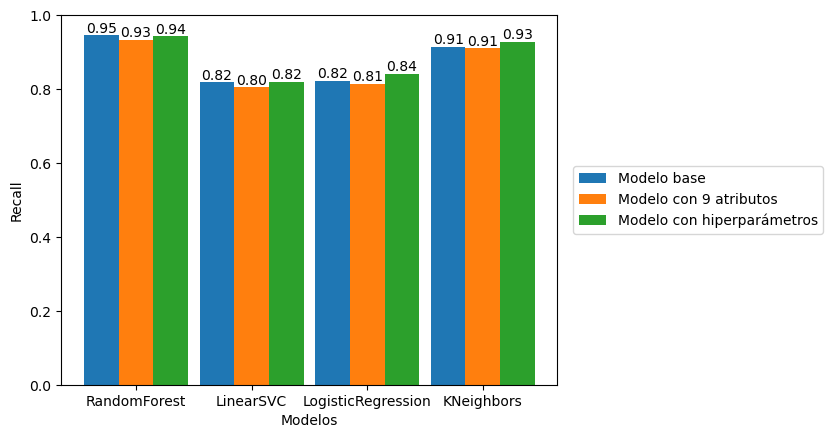

In [38]:
df_res_modelos = {
    'Modelo': ['RandomForest', 'LinearSVC', 'LogisticRegression', 'KNeighbors'],
    'Modelo base': list(resultados_modelos['Recall']),
    'Modelo con 9 atributos': list(resultados_modelos_2['Recall']),
    'Modelo con hiperparámetros': list(resultados_modelos_3['Recall'])
}

# Crear dataframe a partir de de los resultados
df_res_modelos = pd.DataFrame(df_res_modelos)

# Crear los puntos en eje x según el número de modelos
x = np.arange(len(df_res_modelos['Modelo']))
width = 0.3

# Pintar las barras agrupadas
fig, ax = plt.subplots()
bars1 = ax.bar(x - width, df_res_modelos['Modelo base'], width, label='Modelo base')
bars2 = ax.bar(x, df_res_modelos['Modelo con 9 atributos'], width, label='Modelo con 9 atributos')
bars3 = ax.bar(x + width, df_res_modelos['Modelo con hiperparámetros'], width, label='Modelo con hiperparámetros')

# Añadir los valores a cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

# Formateo de x e y
ax.set_xticks(x, df_res_modelos['Modelo'])
ax.set_xlabel('Modelos')
ax.set_ylim(0.0, 1.0)
ax.set_ylabel('Recall')
ax.legend(bbox_to_anchor=(1.55, 0.5), loc='center right')

plt.show()

### Modelo Redes Neuronales

In [39]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from kerastuner.tuners import RandomSearch
import keras_tuner

In [40]:
import tensorflow as tf
import random

# Función para reproducir los resultados de Keras
# Más información: https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras

def reset_seeds():
    np.random.seed(1)
    random.seed(1)
    tf.random.set_seed(2)

reset_seeds()

### Experimento 1: Modelo preliminar de redes neuronales

In [41]:
modelo = Sequential()
modelo.add(Dense(300, input_dim=len(X_train.columns), activation="relu"))
modelo.add(Dense(200, activation="relu"))
modelo.add(Dense(100, activation="relu"))
modelo.add(Dense(4, activation='softmax'))

In [46]:
modelo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 300)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        60,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,804 (335.17 KB)

 Trainable params: 85,804 (335.17 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
modelo.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['Recall'])

In [48]:
historia = modelo.fit(X_train_scaled, to_categorical(y_train), epochs=50, batch_size=64,
                     validation_data=(X_val_scaled, to_categorical(y_val)))

Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - Recall: 0.6136 - loss: 0.7210 - val_Recall: 0.8484 - val_loss: 0.3352
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8722 - loss: 0.3257 - val_Recall: 0.8739 - val_loss: 0.3161
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8915 - loss: 0.2751 - val_Recall: 0.8934 - val_loss: 0.2799
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.9018 - loss: 0.2533 - val_Recall: 0.8972 - val_loss: 0.2619
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.9121 - loss: 0.2302 - val_Recall: 0.9010 - val_loss: 0.2506
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.9135 - loss: 0.2246 - val_Recall: 0.9049 - val_loss: 0.2413
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.9191 - loss: 0.2116 - val_Recall: 0.9087 - val_loss: 0.2438
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.9210 - loss: 0.2100 - val_Recall: 0.9063 - val_loss: 0.2497
Epoch 9/

In [51]:
y_pred = np.argmax(modelo.predict(X_test_scaled) , axis=1)

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [52]:
nn_base = recall_score(y_test, y_pred, average='macro')

nn_base

0.9372180221698142

              precision    recall  f1-score   support

      benign       0.94      0.91      0.92       765
  defacement       0.90      0.93      0.92       749
     malware       0.96      0.95      0.95       621
    phishing       0.96      0.96      0.96       736

    accuracy                           0.94      2871
   macro avg       0.94      0.94      0.94      2871
weighted avg       0.94      0.94      0.94      2871



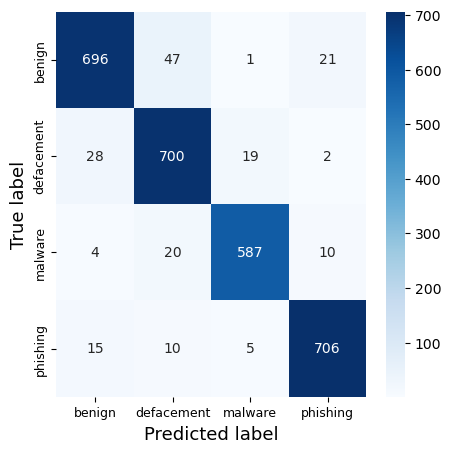

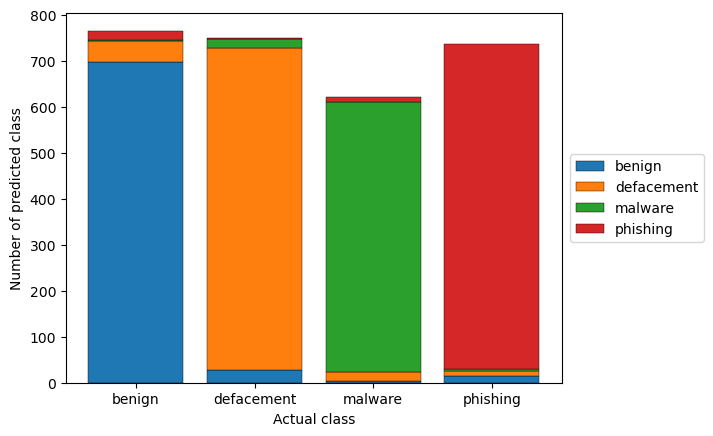

In [53]:
# Informe de las metricas sobre el conjunto de test
print(classification_report(y_test, y_pred, target_names=list(le.classes_)))

# Matriz de confusion sobre el conjunto de test
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
cm = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(le.classes_), yticklabels=list(le.classes_))
cm.set_xlabel('Predicted label', fontsize=13)
cm.set_ylabel('True label', fontsize=13)
plt.xticks(rotation=0, fontsize=9)
plt.yticks(fontsize=9)
plt.show()

# Pintar gráfica predicciones errores
graf_error_pred(y_test, y_pred, list(le.classes_))

### Experimento 2: Redes neuronales con 9 atributos

In [54]:
X_test_red_scaled = scaler9.transform(X_test[col]) # Conjunto test reducido escalado

In [56]:
modelo = Sequential()
modelo.add(Dense(300, input_dim=len(X_train_reduced.columns), activation="relu"))
modelo.add(Dense(200, activation="relu"))
modelo.add(Dense(100, activation="relu"))
modelo.add(Dense(4, activation='softmax'))

modelo.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['Recall'])

# Entrenar y validar con los conjuntos de train y val reducidos
historia = modelo.fit(X_train_red_scaled, to_categorical(y_train), epochs=50, batch_size=64,
                     validation_data=(X_val_red_scaled, to_categorical(y_val)))

y_pred = np.argmax(modelo.predict(X_test_red_scaled) , axis=1) # Prediccion sobre conjunto test reducido escalado

nn_9_col = recall_score(y_test, y_pred, average='macro')

nn_9_col

Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - Recall: 0.6179 - loss: 0.6329 - val_Recall: 0.8634 - val_loss: 0.3363
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8833 - loss: 0.3011 - val_Recall: 0.8840 - val_loss: 0.2853
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8924 - loss: 0.2701 - val_Recall: 0.8913 - val_loss: 0.2650
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8998 - loss: 0.2526 - val_Recall: 0.8993 - val_loss: 0.2561
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.9055 - loss: 0.2419 - val_Recall: 0.9038 - val_loss: 0.2484
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.9096 - loss: 0.2333 - val_Recall: 0.9056 - val_loss: 0.2424
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.9118 - loss: 0.2258 - val_Recall: 0.9087 - val_loss: 0.2388
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.9157 - loss: 0.2197 - val_Recall: 0.9098 - val_loss: 0.2367
Epoch 9/

0.9222953599415746

              precision    recall  f1-score   support

      benign       0.92      0.90      0.91       765
  defacement       0.87      0.92      0.89       749
     malware       0.94      0.92      0.93       621
    phishing       0.97      0.95      0.96       736

    accuracy                           0.92      2871
   macro avg       0.92      0.92      0.92      2871
weighted avg       0.92      0.92      0.92      2871



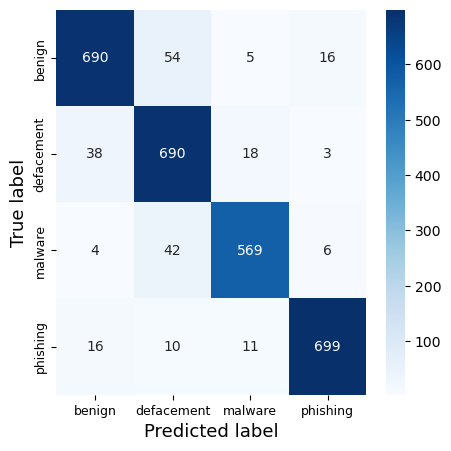

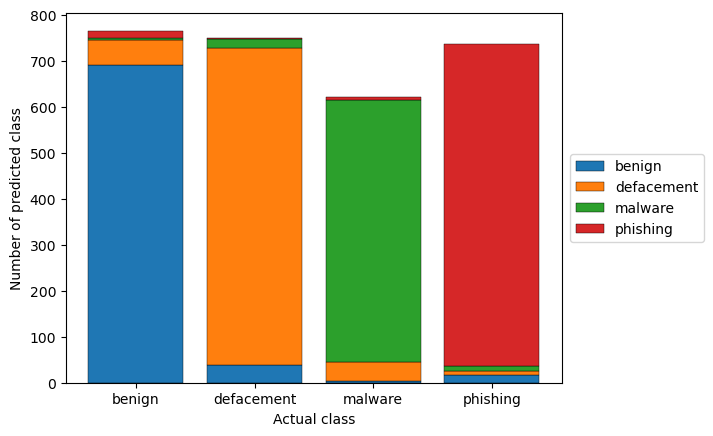

In [57]:
# Informe de las metricas sobre el conjunto de test
print(classification_report(y_test, y_pred, target_names=list(le.classes_)))

# Matriz de confusion sobre el conjunto de test
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
cm = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(le.classes_), yticklabels=list(le.classes_))
cm.set_xlabel('Predicted label', fontsize=13)
cm.set_ylabel('True label', fontsize=13)
plt.xticks(rotation=0, fontsize=9)
plt.yticks(fontsize=9)
plt.show()

# Pintar gráfica predicciones errores
graf_error_pred(y_test, y_pred, list(le.classes_))

### Experimento 3: Redes neuronales con hiperparámetros

In [58]:
def build_model(hp):
    modelo = keras.Sequential()
    
    modelo.add(layers.Dense(units=hp.Int('Capa de entrada', min_value=30, max_value=500),
                                    input_dim = len(X_train.columns),
                                    activation=hp.Choice("activation ", ['relu', 'sigmoid'])))

    for i in range(hp.Int('num_capas', 2, 10)):                 # Numero de capas ocultas
        modelo.add(layers.Dense(units=hp.Int('units_' + str(i), # Numero de neuronas en rango de 30 a 500
                                              min_value=30,
                                              max_value=500,
                                              step=30),
                               activation=hp.Choice("activation " + str(i), ['relu', 'sigmoid'])))
        
    modelo.add(layers.Dense(4, activation='softmax'))
    modelo.compile("adam", "categorical_crossentropy", metrics=['Recall'])  
    return modelo

In [59]:
tuner = RandomSearch(
    build_model,                                                    # Pasar la funcion definida con los hiperparametros
    objective=keras_tuner.Objective('val_recall', direction='max'), # Optimizar el recall de las validaciones
    max_trials=5,
    executions_per_trial=3,
    project_name="keras_tuner_resultados_multi")                    # Guardar las busquedas en la carpeta indicada

Reloading Tuner from .\keras_tuner_resultados_multi\tuner0.json


In [60]:
tuner.search_space_summary()

Search space summary
Default search space size: 19
Capa de entrada (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 500, 'step': 1, 'sampling': 'linear'}
activation  (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
num_capas (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 500, 'step': 30, 'sampling': 'linear'}
activation 0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 500, 'step': 30, 'sampling': 'linear'}
activation 1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 500, 'step': 30, 'sampling': 'linear'}
activation 2 (Choice)


In [61]:
tuner.search(X_train_scaled, to_categorical(y_train), epochs=50,
                     validation_data=(X_val_scaled, to_categorical(y_val)))

In [62]:
tuner.results_summary()

Results summary
Results in .\keras_tuner_resultados_multi
Showing 10 best trials
Objective(name="val_recall", direction="max")

Trial 2 summary
Hyperparameters:
Capa de entrada: 357
activation : relu
num_capas: 4
units_0: 390
activation 0: relu
units_1: 390
activation 1: relu
units_2: 270
activation 2: sigmoid
units_3: 120
activation 3: sigmoid
units_4: 300
activation 4: relu
units_5: 360
activation 5: sigmoid
units_6: 360
activation 6: relu
units_7: 30
activation 7: sigmoid
Score: 0.9382113814353943

Trial 0 summary
Hyperparameters:
Capa de entrada: 271
activation : relu
num_capas: 6
units_0: 270
activation 0: relu
units_1: 360
activation 1: relu
units_2: 30
activation 2: relu
units_3: 30
activation 3: relu
units_4: 30
activation 4: relu
units_5: 30
activation 5: relu
Score: 0.937049945195516

Trial 3 summary
Hyperparameters:
Capa de entrada: 64
activation : sigmoid
num_capas: 3
units_0: 480
activation 0: relu
units_1: 60
activation 1: sigmoid
units_2: 360
activation 2: sigmoid
units_

In [63]:
mejores_hp = tuner.get_best_hyperparameters()[0] # Mejores parametros de la busqueda
modelo_hp = tuner.hypermodel.build(mejores_hp)   # Modelo con los mejores parametros

In [64]:
modelo_hp.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 357)            │         6,069 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 390)            │       139,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 390)            │       152,490 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 270)            │       105,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 120)            │        32,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           484 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 436,753 (1.67 MB)

 Trainable params: 436,753 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
historia_hp = modelo_hp.fit(X_train_scaled, to_categorical(y_train), epochs=50, 
                          validation_data=(X_val_scaled, to_categorical(y_val)))

Epoch 1/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - Recall: 0.6720 - loss: 0.6346 - val_Recall: 0.8519 - val_loss: 0.3899
Epoch 2/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - Recall: 0.8821 - loss: 0.3284 - val_Recall: 0.8909 - val_loss: 0.3145
Epoch 3/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - Recall: 0.8977 - loss: 0.2845 - val_Recall: 0.8983 - val_loss: 0.2763
Epoch 4/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - Recall: 0.9046 - loss: 0.2590 - val_Recall: 0.9003 - val_loss: 0.2608
Epoch 5/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - Recall: 0.9137 - loss: 0.2426 - val_Recall: 0.9073 - val_loss: 0.2563
Epoch 6/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - Recall: 0.9182 - loss: 0.2250 - val_Recall: 0.9021 - val_loss: 0.2640
Epoch 7/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - Recall: 0.9236 - loss: 0.2198 - val_Recall: 0.9070 - val_loss: 0.2471
Epoch 8/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - Recall: 0.9286 - loss: 0.2025 - val_Recall: 0.9226 - val_loss: 0.2280
Epoch 9/

In [66]:
y_pred = np.argmax(modelo_hp.predict(X_test_scaled) , axis=1)

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [67]:
# Predicciones sobre el conjunto test modelo con hiperparametros
nn_hiper = recall_score(y_test, y_pred, average='macro')

nn_hiper

0.9292218954548725

              precision    recall  f1-score   support

      benign       0.92      0.92      0.92       765
  defacement       0.91      0.91      0.91       749
     malware       0.94      0.93      0.94       621
    phishing       0.94      0.96      0.95       736

    accuracy                           0.93      2871
   macro avg       0.93      0.93      0.93      2871
weighted avg       0.93      0.93      0.93      2871



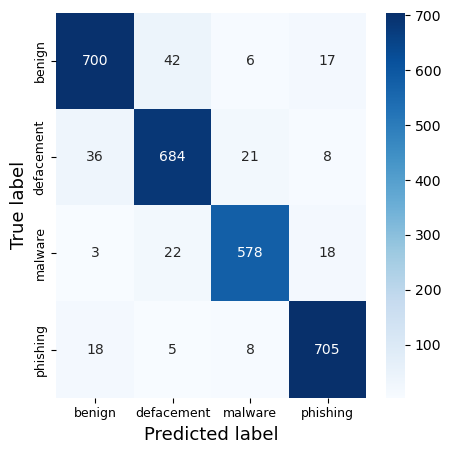

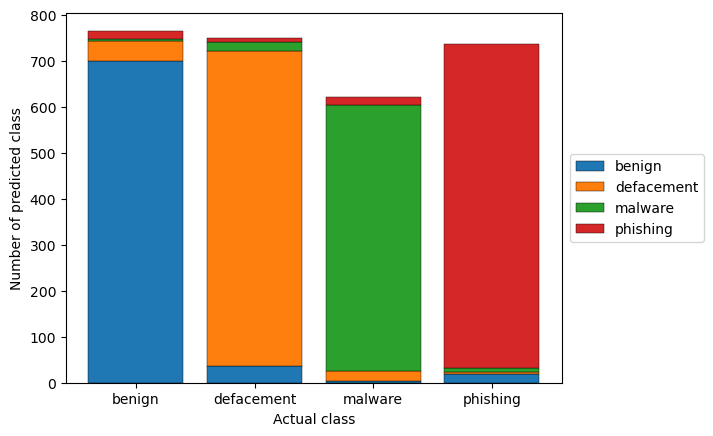

In [68]:
# Informe de las metricas sobre el conjunto de test
print(classification_report(y_test, y_pred, target_names=list(le.classes_)))

# Matriz de confusion sobre el conjunto de test
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
cm = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(le.classes_), yticklabels=list(le.classes_))
cm.set_xlabel('Predicted label', fontsize=13)
cm.set_ylabel('True label', fontsize=13)
plt.xticks(rotation=0, fontsize=9)
plt.yticks(fontsize=9)
plt.show()

# Pintar gráfica predicciones errores
graf_error_pred(y_test, y_pred, list(le.classes_))

### Comparativas de los modelos

In [69]:
nn_res = {
    'Modelo': ['NeuralNetwork'],
    'Modelo base': nn_base,
    'Modelo con 9 atributos': nn_9_col,
    'Modelo con hiperparámetros': nn_hiper
}

df_res_modelos_f = pd.concat([df_res_modelos, pd.DataFrame(nn_res)], ignore_index=True)

df_res_modelos_f

,Modelo,Modelo base,Modelo con 9 atributos,Modelo con hiperparámetros
0,RandomForest,0.945643,0.932988,0.942380
1,LinearSVC,0.818708,0.804342,0.818753
2,LogisticRegression,0.821688,0.814954,0.841057
3,KNeighbors,0.914454,0.910461,0.927520
4,NeuralNetwork,0.937218,0.922295,0.929222


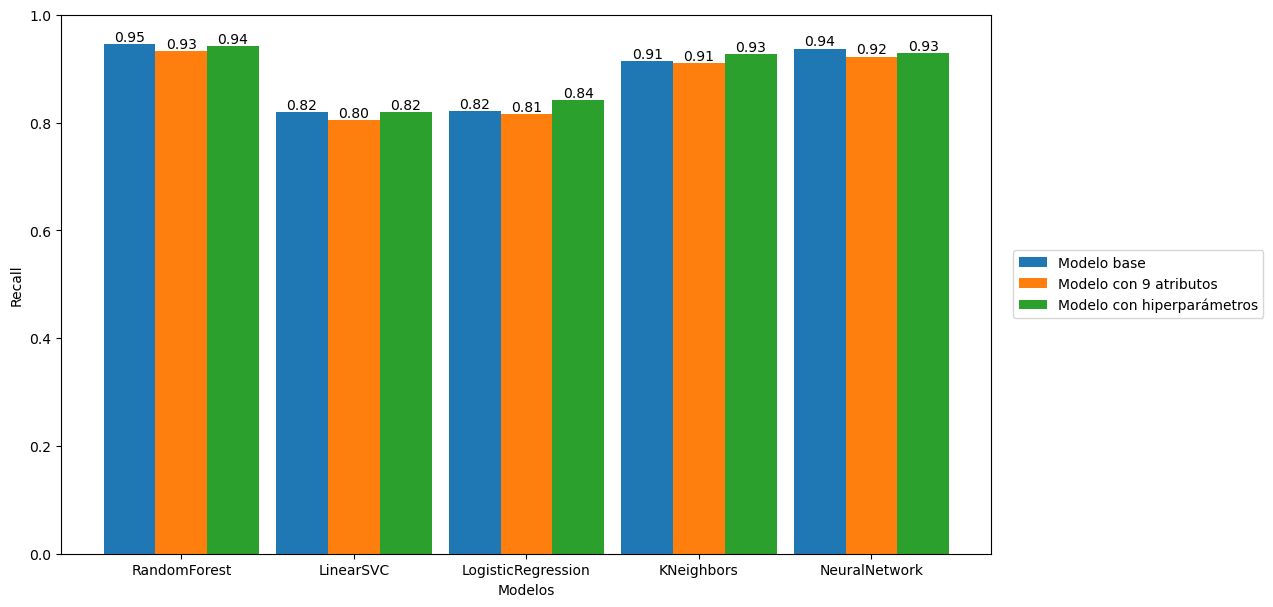

In [70]:
# Crear los puntos en eje x según el número de modelos
x = np.arange(len(df_res_modelos_f['Modelo']))
width = 0.3


# Pintar las barras agrupadas
fig, ax = plt.subplots(figsize=(12, 7))
bars1 = ax.bar(x - width, df_res_modelos_f['Modelo base'], width, label='Modelo base')
bars2 = ax.bar(x, df_res_modelos_f['Modelo con 9 atributos'], width, label='Modelo con 9 atributos')
bars3 = ax.bar(x + width, df_res_modelos_f['Modelo con hiperparámetros'], width, label='Modelo con hiperparámetros')

# Añadir los valores a cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

# Formateo de x e y
ax.set_xticks(x, df_res_modelos_f['Modelo'])
ax.set_xlabel('Modelos')
ax.set_ylim(0.0, 1.0)
ax.set_ylabel('Recall')
ax.legend(bbox_to_anchor=(1.3, 0.5), loc='center right')
plt.show()

### Predicciones sobre el conjunto de test. Resultados

En esta sección se va a coger los modelos que mejores recall han obtenido sobre el conjunto de validación, y realizar predicciones sobre el conjunto de test.

Los mejores resultados obtenido por cada modelos son:

- Random Forest, modelo base
- LinearSVC, modelo base
- LogisticRegression, modelo con hiperparametro
- K-Neighbors, modelo con hiperparametro
- RN, modelo base

In [92]:
# Random Forest modelo base

start = time.time()

clf_rf = RandomForestClassifier(random_state=23)
clf_rf.fit(X_train_scaled, y_train)
pred = clf_rf.predict(X_test_scaled)
recall_1 = recall_score(y_test, pred, average='macro')
precision_1 = precision_score(y_test, pred, average='macro')
f1_1 = f1_score(y_test, pred, average='macro')
acc_1 = accuracy_score(y_test, pred)

end = time.time()
tiempo_de_ejecucion_1 = end - start
recall_1

0.9507261661549806

In [93]:
# LinearSVC modelo base

start = time.time()

clf_svc = LinearSVC(random_state=23)
clf_svc.fit(X_train_scaled, y_train)
pred = clf_svc.predict(X_test_scaled)
recall_2 = recall_score(y_test, pred, average='macro')
precision_2 = precision_score(y_test, pred, average='macro')
f1_2 = f1_score(y_test, pred, average='macro')
acc_2 = accuracy_score(y_test, pred)

end= time.time()
tiempo_de_ejecucion_2 = end - start
recall_2

0.8305548607767637

In [94]:
# LogisticRegression con hiperparametros

start = time.time()

clf_lr = LogisticRegression(C=0.001, penalty=None, random_state=23, solver='newton-cg')
clf_lr.fit(X_train_scaled, y_train)
pred = clf_lr.predict(X_test_scaled)
recall_3 = recall_score(y_test, pred, average='macro')
precision_3 = precision_score(y_test, pred, average='macro')
f1_3 = f1_score(y_test, pred, average='macro')
acc_3 = accuracy_score(y_test, pred)

end = time.time()
tiempo_de_ejecucion_3 = end - start
recall_3

0.8496417719758452

In [95]:
# K-neighbors con hiperparametros

start = time.time()

clf_kn = KNeighborsClassifier(metric='manhattan', n_neighbors=4, weights='distance')
clf_kn.fit(X_train_scaled, y_train)
pred = clf_kn.predict(X_test_scaled)
recall_4 = recall_score(y_test, pred, average='macro')
precision_4 = precision_score(y_test, pred, average='macro')
f1_4 = f1_score(y_test, pred, average='macro')
acc_4 = accuracy_score(y_test, pred)

end = time.time()
tiempo_de_ejecucion_4 = end - start
recall_4

0.9326390106135009

In [75]:
# Redes neuronales modelo base con 1 entrada y salida 3 capas ocultas

start = time.time()

nn_keras = Sequential()

nn_keras.add(Dense(300, input_dim=len(X_train.columns), activation="relu"))
nn_keras.add(Dense(200, activation="relu"))
nn_keras.add(Dense(100, activation="relu"))
nn_keras.add(Dense(4, activation='softmax'))

nn_keras.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['Recall'])

historia = nn_keras.fit(X_train_scaled, to_categorical(y_train), epochs=50, batch_size=64,
                     validation_data=(X_val_scaled, to_categorical(y_val)))

pred = np.argmax(nn_keras.predict(X_test_scaled) , axis=1)
recall_5 = recall_score(y_test, pred, average='macro')

end = time.time()
tiempo_de_ejecucion_5 = end - start
recall_5

Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - Recall: 0.5941 - loss: 0.7416 - val_Recall: 0.8383 - val_loss: 0.3523
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8679 - loss: 0.3496 - val_Recall: 0.8808 - val_loss: 0.2895
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8848 - loss: 0.3062 - val_Recall: 0.8871 - val_loss: 0.2758
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8985 - loss: 0.2590 - val_Recall: 0.8920 - val_loss: 0.2688
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.9075 - loss: 0.2420 - val_Recall: 0.8997 - val_loss: 0.2528
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.9131 - loss: 0.2294 - val_Recall: 0.9024 - val_loss: 0.2477
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.9140 - loss: 0.2290 - val_Recall: 0.9077 - val_loss: 0.2392
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.9208 - loss: 0.2054 - val_Recall: 0.9150 - val_loss: 0.2310
Epoch 9/

0.9320829761427349

In [98]:
precision_5 = precision_score(y_test, pred, average='macro')
f1_5 = f1_score(y_test, pred, average='macro')
acc_5 = accuracy_score(y_test, pred)

In [97]:
recall = []
f1 = []
precision = []
acc = []
tiempo_ejecucion = []

recall.append(recall_1)
recall.append(recall_2)
recall.append(recall_3)
recall.append(recall_4)
recall.append(recall_5)

f1.append(f1_1)
f1.append(f1_2)
f1.append(f1_3)
f1.append(f1_4)
f1.append(f1_5)

precision.append(precision_1)
precision.append(precision_2)
precision.append(precision_3)
precision.append(precision_4)
precision.append(precision_5)

acc.append(acc_1)
acc.append(acc_2)
acc.append(acc_3)
acc.append(acc_4)
acc.append(acc_5)

tiempo_ejecucion.append(tiempo_de_ejecucion_1)
tiempo_ejecucion.append(tiempo_de_ejecucion_2)
tiempo_ejecucion.append(tiempo_de_ejecucion_3)
tiempo_ejecucion.append(tiempo_de_ejecucion_4)
tiempo_ejecucion.append(tiempo_de_ejecucion_5)

In [99]:
print('Lista de accuracy: ', acc)
print('Lista de recall: ', recall)
print('Lista de precision: ', precision)
print('Lista de f1-score: ', f1)
print('Tiempo de ejeucicion', tiempo_ejecucion)

Lista de accuracy:  [0.9508881922675027, 0.8394287704632533, 0.8547544409613375, 0.931382793451759, 0.9324277255311738]
Lista de recall:  [0.9507261661549806, 0.8305548607767637, 0.8496417719758452, 0.9326390106135009, 0.9320829761427349]
Lista de precision:  [0.9531374710357651, 0.8478995646974014, 0.8559438432576929, 0.9334535632416732, 0.9343803406501626]
Lista de f1-score:  [0.9516081073345487, 0.8316735537604175, 0.8509825775979081, 0.9326719857671707, 0.9330762853116934]
Tiempo de ejeucicion [1.970841646194458, 0.20812273025512695, 1.3996918201446533, 0.3832237720489502, 41.21290159225464]


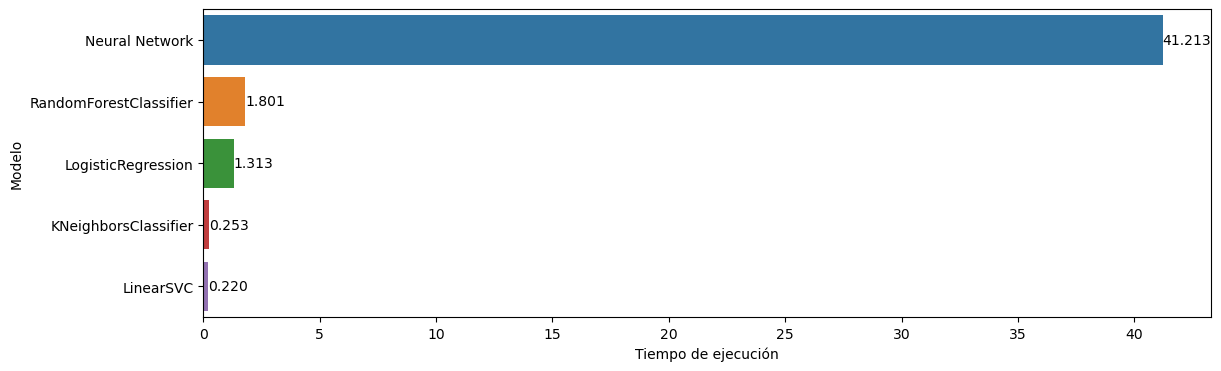

In [78]:
tiempos = pd.DataFrame(
    {
        'Modelo': ['RandomForestClassifier', 'LinearSVC', 'LogisticRegression', 'KNeighborsClassifier',
                  'Neural Network'],
        'Tiempo de ejecución': tiempo_ejecucion        
    }

)

tiempos_sorted = tiempos.sort_values(by='Tiempo de ejecución', ascending=False)

plt.figure(figsize=(13,4))
ax = sns.barplot(x='Tiempo de ejecución', y='Modelo', data=tiempos_sorted)
for i in ax.containers:
    ax.bar_label(i, fmt='%.3f')
plt.show()

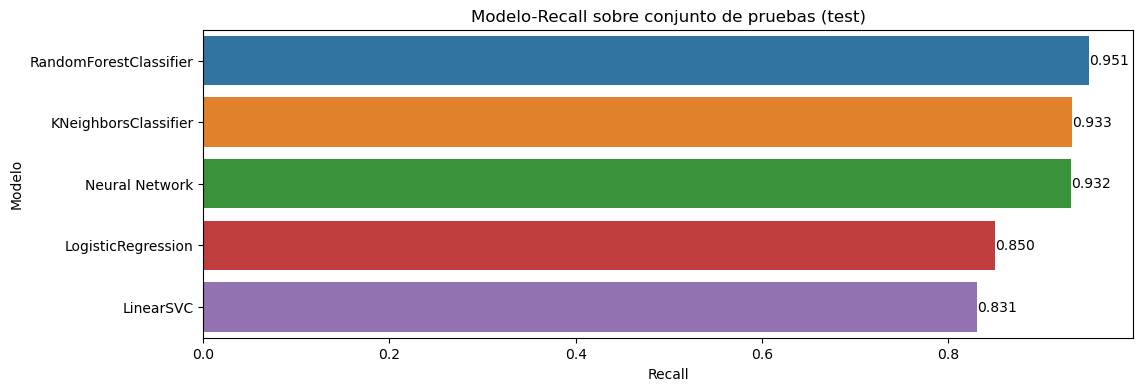

In [79]:
resultados_modelos = pd.DataFrame(
    {
        'Modelo': ['RandomForestClassifier', 'LinearSVC', 'LogisticRegression', 'KNeighborsClassifier',
                  'Neural Network'],
        'Recall': recall
    }
)

res_sorted = resultados_modelos.sort_values(by='Recall', ascending=False)

plt.figure(figsize=(12,4))
ax = sns.barplot(x='Recall', y='Modelo', data=res_sorted)
for i in ax.containers:
    ax.bar_label(i, fmt='%.3f')
plt.title('Modelo-Recall sobre conjunto de pruebas (test)')
plt.show()

### Validación cruzada

In [80]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer

In [81]:
X, y = separar_etiquetas(df_copy, 'clases', 'url', 'type') # Separar el conjunto entero en X e y

X = scaler.transform(X) # Escalar X

X.shape, y.shape

((19134, 16), (19134,))

In [82]:
def modelo_Keras():
    
    modelo = Sequential()
    modelo.add(Dense(300, input_dim=len(X_train.columns), activation="relu"))
    modelo.add(Dense(200, activation="relu"))
    modelo.add(Dense(100, activation="relu"))
    modelo.add(Dense(4, activation='softmax'))
    modelo.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['Recall'])
    
    return modelo

In [83]:
cv_modelos = {
    'RandomForestClassifier': clf_rf,
    'LinearSVC': clf_svc,
    'LogisticRegression': clf_lr,
    'KNeighborsClassifier': clf_kn,
    'NeuralNetwork': KerasClassifier(model=modelo_Keras, epochs=20, batch_size=10)
}

cv = KFold(n_splits=10, shuffle=True, random_state=9)

# Métrica de recall para la validación cruzada
recall = make_scorer(recall_score, average='macro')

resultados_acc_cv = {}
resultados_recall_cv = {}

for nombre_modelos, modelo in cv_modelos.items():

    try:
        acc_cv_res = cross_val_score(modelo, X, y, cv=cv, scoring='accuracy')
        recall_cv_res = cross_val_score(modelo, X, y, cv=cv, scoring=recall)
        resultados_acc_cv[nombre_modelos] = acc_cv_res
        resultados_recall_cv[nombre_modelos] = recall_cv_res
    # Modelo de redes neuronales
    except Exception:        
        acc_cv_res = cross_val_score(modelo, X, to_categorical(y), cv=cv, scoring='accuracy')
        recall_cv_res = cross_val_score(modelo, X, to_categorical(y), cv=cv, scoring=recall)
        resultados_acc_cv[nombre_modelos] = acc_cv_res
        resultados_recall_cv[nombre_modelos] = recall_cv_res

Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - Recall: 0.7533 - loss: 0.6250
Epoch 2/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - Recall: 0.8839 - loss: 0.2927
Epoch 3/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - Recall: 0.9024 - loss: 0.2610
Epoch 4/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9079 - loss: 0.2430
Epoch 5/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - Recall: 0.9189 - loss: 0.2200
Epoch 6/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - Recall: 0.9227 - loss: 0.2083
Epoch 7/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9278 - loss: 0.1918
Epoch 8/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9300 - loss: 0.1870
Epoch 9/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - Recall: 0.9335 - loss: 0.1711
Epoch 10/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - Recall: 0.9372 - loss: 0.1643
Epoch 11/20
1722/1722 ━━━━━━━

1722/1722 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9283 - loss: 0.1895
Epoch 7/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9333 - loss: 0.1764
Epoch 8/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9343 - loss: 0.1716
Epoch 9/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9364 - loss: 0.1668
Epoch 10/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9414 - loss: 0.1563
Epoch 11/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9439 - loss: 0.1546
Epoch 12/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - Recall: 0.9454 - loss: 0.1416
Epoch 13/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - Recall: 0.9481 - loss: 0.1367
Epoch 14/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - Recall: 0.9497 - loss: 0.1322
Epoch 15/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9533 - loss: 0.1258
Epoch 16/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9532 - loss: 0.1244
Epoch 17/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - R

1723/1723 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9420 - loss: 0.1505
Epoch 13/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9466 - loss: 0.1393
Epoch 14/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9481 - loss: 0.1384
Epoch 15/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9506 - loss: 0.1272
Epoch 16/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9493 - loss: 0.1307
Epoch 17/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - Recall: 0.9529 - loss: 0.1211
Epoch 18/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - Recall: 0.9543 - loss: 0.1243
Epoch 19/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - Recall: 0.9540 - loss: 0.1179
Epoch 20/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - Recall: 0.9582 - loss: 0.1117
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - Recall: 0.7680 - loss: 0.5554
Epoch 2/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.8931 - loss: 0.2773
Epoch 3/20
1723/

1723/1723 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - Recall: 0.9513 - loss: 0.1209
Epoch 19/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - Recall: 0.9559 - loss: 0.1179
Epoch 20/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9558 - loss: 0.1149
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - Recall: 0.7519 - loss: 0.5972
Epoch 2/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - Recall: 0.8818 - loss: 0.2956
Epoch 3/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - Recall: 0.9001 - loss: 0.2571
Epoch 4/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - Recall: 0.9109 - loss: 0.2309
Epoch 5/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9187 - loss: 0.2178
Epoch 6/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9249 - loss: 0.2039
Epoch 7/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - Recall: 0.9262 - loss: 0.1977
Epoch 8/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9301 - loss: 0.1829
Epoch 9/20
1722/1722 ━

1722/1722 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - Recall: 0.9051 - loss: 0.2436
Epoch 4/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9127 - loss: 0.2230
Epoch 5/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9220 - loss: 0.2077
Epoch 6/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9281 - loss: 0.1924
Epoch 7/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - Recall: 0.9329 - loss: 0.1779
Epoch 8/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9348 - loss: 0.1749
Epoch 9/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9379 - loss: 0.1691
Epoch 10/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9433 - loss: 0.1538
Epoch 11/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9425 - loss: 0.1584
Epoch 12/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9450 - loss: 0.1439
Epoch 13/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9511 - loss: 0.1337
Epoch 14/20
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Reca

1723/1723 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9356 - loss: 0.1672
Epoch 10/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9390 - loss: 0.1587
Epoch 11/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - Recall: 0.9417 - loss: 0.1579
Epoch 12/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - Recall: 0.9466 - loss: 0.1450
Epoch 13/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9457 - loss: 0.1456
Epoch 14/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - Recall: 0.9490 - loss: 0.1390
Epoch 15/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - Recall: 0.9511 - loss: 0.1322
Epoch 16/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9509 - loss: 0.1286
Epoch 17/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.9543 - loss: 0.1222
Epoch 18/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - Recall: 0.9547 - loss: 0.1163
Epoch 19/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - Recall: 0.9532 - loss: 0.1209
Epoch 20/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step 

1723/1723 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - Recall: 0.9477 - loss: 0.1416
Epoch 16/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - Recall: 0.9509 - loss: 0.1231
Epoch 17/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - Recall: 0.9525 - loss: 0.1207
Epoch 18/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - Recall: 0.9551 - loss: 0.1197
Epoch 19/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - Recall: 0.9582 - loss: 0.1128
Epoch 20/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - Recall: 0.9560 - loss: 0.1154
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [84]:
# Diccionario combinado = 0.2 * media_resultados_de_exactitud_por_modelo + 0.8 * media_resultados_de_recall_por_modelo
from statistics import mean 

resultados_cv_finales = {key: mean(0.2 * resultados_acc_cv[key] + 0.8 * resultados_recall_cv[key]) for key in resultados_acc_cv}

resultados_cv_finales

{'RandomForestClassifier': 0.9508675605906608,
 'LinearSVC': 0.8316876060032867,
 'LogisticRegression': 0.8475510468035412,
 'KNeighborsClassifier': 0.9319399514419324,
 'NeuralNetwork': 0.931720978705289}

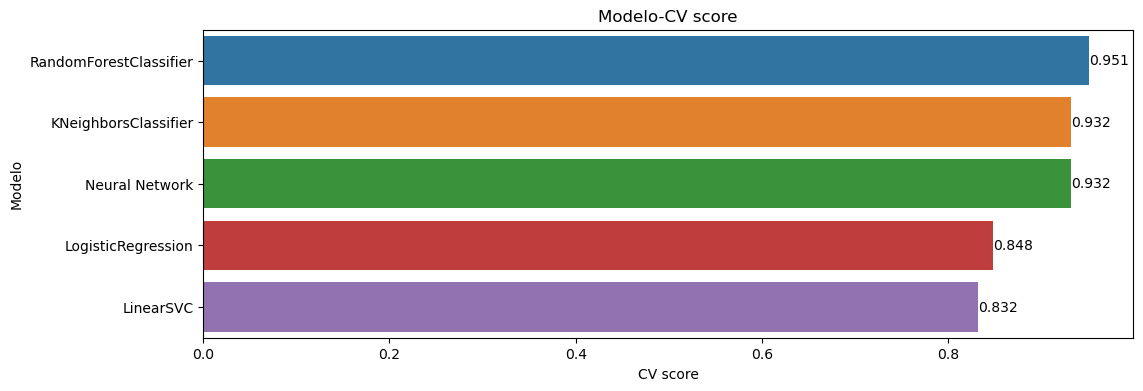

In [85]:
res_combinado = [value for value in resultados_cv_finales.values()]

resultados_cv = pd.DataFrame(
    {
        'Modelo': ['RandomForestClassifier', 'LinearSVC', 'LogisticRegression', 'KNeighborsClassifier',
                  'Neural Network'],
        'CV score': res_combinado
    }
)

res_sorted = resultados_cv.sort_values(by='CV score', ascending=False)

plt.figure(figsize=(12,4))
ax = sns.barplot(x='CV score', y='Modelo', data=res_sorted)
for i in ax.containers:
    ax.bar_label(i, fmt='%.3f')
plt.title('Modelo-CV score')
plt.show()

In [37]:
# Guardar modelo de random forest
import joblib

joblib.dump(clf_rf, 'rf.pkl')

['rf.pkl']

In [70]:
# Guardar modelo de redes neuronales
nn_keras.save('nn_keras.h5')

In [32]:
# Guardar el conjunto de test para uso posterior
test_csv = test_set.iloc[:, [0, 1]]
test_csv.to_csv('test.csv', index=False)